# Baseline

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa

from glob import glob
from tqdm import tqdm

import cv2

import argparse
import wandb
from wandb.keras import WandbCallback
wandb.init(project="DACON_235894", name="Baseline")

parser = argparse.ArgumentParser(description='Baseline')
parser.add_argument('--resize_size', default=224, type=int)
parser.add_argument('--optimizer', default="adam", type=str) # adam or sgd
parser.add_argument('--learning_rate', default=0.0003, type=float)
parser.add_argument('--loss', default="cc", type=str) # cc or fl
parser.add_argument('--label_smoothing', default=0, type=float) # 0 or 0.1
parser.add_argument('--class_weight', default=False, type=bool) # False or True
parser.add_argument('--batch_size', default=32, type=int)
parser.add_argument('--epochs', default=10, type=int)
parser.add_argument('--validation_split', default=0.2, type=float)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

wandb.config.update(args)

resize_size=args.resize_size
BATCH_SIZE=args.batch_size
EPOCHS=args.epochs
VALIDATION_SPLIT=args.validation_split
SEED=args.seed

if args.optimizer == "adam":
    lr = tf.keras.optimizers.schedules.CosineDecay(args.learning_rate, decay_steps=1000)
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
elif args.optimizer == "sgd":
    optim = optimizer=tf.keras.optimizers.SGD(learning_rate=args.learning_rate, momentum=0.9)

if args.loss == "cc":
    loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=args.label_smoothing)
elif args.loss == "fl":
    loss_function = tfa.losses.SigmoidFocalCrossEntropy()

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

wandb: Currently logged in as: gnoeyheat (use `wandb login --relogin` to force relogin)


## Preprocessing

In [2]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = tf.image.central_crop(img, 0.9).numpy()
    img = cv2.resize(img, (resize_size, resize_size), cv2.INTER_AREA)
    return img

train_png = sorted(glob('raw_data/train/*.png'))
test_png = sorted(glob('raw_data/test/*.png'))

train_imgs = [img_load(m) for m in tqdm(train_png)]
test_imgs = [img_load(n) for n in tqdm(test_png)]

train_imgs = np.array(train_imgs)
test_imgs = np.array(test_imgs)

train_y = pd.read_csv("raw_data/train_df.csv")

train_labels = train_y["label"]
label_unique = sorted(np.unique(train_labels))
label_unique = {key : value for key, value in zip(label_unique, range(len(label_unique)))}

train_imgs.shape, train_labels.shape, test_imgs.shape, train_imgs.dtype

100%|██████████████████████████████████████████████████████████████████████████████| 2154/2154 [01:29<00:00, 24.16it/s]


((4277, 224, 224, 3), (4277,), (2154, 224, 224, 3), dtype('uint8'))

## Training

In [3]:
train_imgs = train_imgs.astype("float32")

X_train, X_val, y_train, y_val = train_test_split(train_imgs, train_labels,
                                                  test_size=VALIDATION_SPLIT, random_state=SEED, stratify=train_labels)

y_train = [label_unique[k] for k in y_train]
y_train = np.array(y_train)

y_val = [label_unique[k] for k in y_val]
y_val = np.array(y_val)

y_train=tf.keras.utils.to_categorical(y_train)
y_val=tf.keras.utils.to_categorical(y_val)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((3421, 224, 224, 3), (856, 224, 224, 3), (3421, 88), (856, 88))

In [4]:
augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("vertical"),
        layers.experimental.preprocessing.RandomCrop(int(resize_size*0.9), int(resize_size*0.9)),
        layers.experimental.preprocessing.Resizing(resize_size, resize_size),
        layers.experimental.preprocessing.RandomRotation(0.5, fill_mode='constant', fill_value=0.0),
])

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(len(X_train))
    .batch(BATCH_SIZE)
    .map(lambda x, y: (augmentation(x, training=True), y),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [5]:
pretrained_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

model=tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(y_train.shape[1], activation="softmax")
])

model.compile(
    optimizer=optim,
    loss=loss_function,
    metrics=tfa.metrics.F1Score(num_classes=y_train.shape[1], average="macro")
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 88)                112728    
                                                                 
Total params: 4,162,299
Trainable params: 4,120,276
Non-trainable params: 42,023
_________________________________________________________________


In [6]:
checkpoint_path=f"load_model/{parser.description}"

callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_f1_score',
        patience=5,
        mode="max",
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_f1_score",
        save_best_only=True,
        save_weights_only=True,
        mode="max",
    )
]

if args.class_weight==True:
    class_weight = np.argmax(y_train, axis=1)
    class_weight = (1 / np.bincount(class_weight)) * (len(class_weight))
    class_weight = class_weight / class_weight.sum()
    class_weight = {key : value for key, value in zip(range(len(class_weight)), class_weight)}
else:
    class_weight = None

history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[callback, WandbCallback()],
    validation_data=val_ds,
    class_weight=class_weight
)

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 1.2211 - f1_score: 0.1551

C:\Users\Taehyeong\anaconda3\envs\DACON_tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


107/107 [==============================] - 49s 304ms/step - loss: 1.2211 - f1_score: 0.1551 - val_loss: 0.7328 - val_f1_score: 0.1639 - _timestamp: 1652359464.0000 - _runtime: 330.0000
Epoch 2/10
107/107 [==============================] - 29s 268ms/step - loss: 0.6202 - f1_score: 0.2675 - val_loss: 0.5601 - val_f1_score: 0.2963 - _timestamp: 1652359495.0000 - _runtime: 361.0000
Epoch 3/10
107/107 [==============================] - 30s 273ms/step - loss: 0.4774 - f1_score: 0.4142 - val_loss: 0.4727 - val_f1_score: 0.3777 - _timestamp: 1652359526.0000 - _runtime: 392.0000
Epoch 4/10
107/107 [==============================] - 29s 265ms/step - loss: 0.4011 - f1_score: 0.4667 - val_loss: 0.4052 - val_f1_score: 0.4030 - _timestamp: 1652359557.0000 - _runtime: 423.0000
Epoch 5/10
107/107 [==============================] - 29s 266ms/step - loss: 0.3445 - f1_score: 0.5391 - val_loss: 0.3729 - val_f1_score: 0.4589 - _timestamp: 1652359587.0000 - _runtime: 453.0000
Epoch 6/10
107/107 [===========

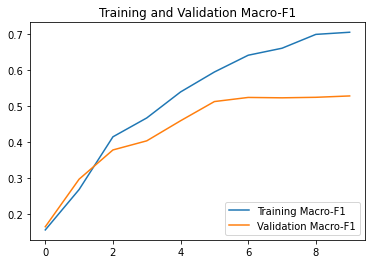

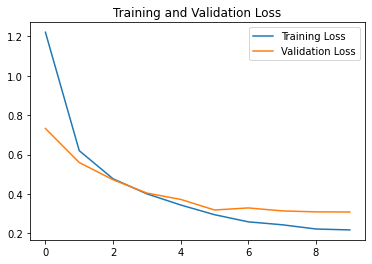

In [7]:
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

loss=history.history['loss']
val_loss=history.history['val_loss']

plt.plot(acc, label='Training Macro-F1')
plt.plot(val_acc, label='Validation Macro-F1')
plt.legend(loc='lower right')
plt.title('Training and Validation Macro-F1')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
model.load_weights(checkpoint_path)

## Inference

In [9]:
test_ds = (
    tf.data.Dataset.from_tensor_slices((test_imgs))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [10]:
pred_prob = model.predict(test_ds)
f_pred = np.argmax(pred_prob, axis=1)
label_decoder = {val:key for key, val in label_unique.items()}
f_result = [label_decoder[result] for result in f_pred]

pd.Series(f_result).value_counts()

screw-good                187
cable-good                153
transistor-good           149
pill-good                 141
capsule-good              132
                         ... 
wood-combined               2
pill-contamination          2
screw-thread_top            1
capsule-faulty_imprint      1
grid-thread                 1
Length: 77, dtype: int64

In [11]:
submission = pd.read_csv("raw_data/sample_submission.csv")
submission["label"] = f_result
submission.to_csv(f"{parser.description}.csv", index=False)